# Tarea 3 - MEL

Alejandro Mantilla - 201711304

Ximena Palacio - 201730995

## Índice

- [Parte A](#Parte-A.-Problemas-computacionales.)

    - [Problema 1](#Problema-1.-Bootstrap-para-pruebas-con-restricciones-lineales.)
    - [Problema 2](#Problem-2.-Método-de-estimación-robusta.)

- [Parte B](#Parte-B.-Problemas-teóricos,-conceptuales-y-experimentales.)

    - [Problema BONO](#Problema-BONO.-Uso-de-leverage-para-medidas-de-desempeño.)
    - [Problema 3](#Problema-3.-Problemas-de-especificación-y-selección-de-modelos.)
    
- [Parte C](#Parte-C.-Problemas-aplicados-con-datos-reales.)

    - [Problema 4](#Problema-4.-Ventas-de-secadoras-eléctricas-en-Bogotá.)
    - [Problema 5](#Problema-5.-Efectos-de-medidas-preventivas-en-la-severidad-del-coronavirus.)

## Parte A. Problemas computacionales.

### Problema 1. Bootstrap para pruebas con restricciones lineales.

#### 1. Construya el código que haga el procedimietno que se describe para constrastar $H_0$ de manera gráfica.

El método de bootstrap no sólamente sirve para construir intervalos de confianza, sino para contrastar
pruebas de hipótesis. En este problema, realizaremos una prueba de hipótesis gráfica por medio de
_bootstrap_. En este caso, se hace una prueba de hipótesis con restricciones lineales del tipo $H_{0}: A\beta = c$, donde $q = 2$.

Tenga en cuenta que la hipótesis nula se puede escribir como:

$$
H_{0}: \begin{cases} 
          \textbf{a}_{1}^{T}\beta = c_1 \\
          \textbf{a}_{2}^{T}\beta = c_2
       \end{cases}
$$

Con las repeticiones del _bootstrap_, calcule en cada iteración los valores de $\textbf{a}_{1}^{T}$ y $\textbf{a}_{2}^{T}$. Luego con estos $B$ puntos, se puede construir la elipse de confianza empírica que cubre el 95% de los datos. Después, en el mismo gráfco puede dibujar el punto $(c_{1}, c_{2})$, y si este cae dentro de la elipse, no se rechaza la hipótesis nula.

1. Construya el código que haga el procedimiento que se describe para constrastar $H_{0}$ de manera gráfica. Puede usar como guía el siguiente código:

```r
library(ellipse)
x1 <- rnorm(500, 20, 3)
x2 <- .5*x1+rnorm(500, 1, 3)
plot(x1, x2)
x <- cbind(x1, x2)
el <- ellipse(x, centre=colMeans(x), level=0.95)
plot(x1, x2)
points(el, type="l")
points(25, 5, col=2, lwd=2)

```

In [1]:
library(lmridge) # Librería lmridge para regresión Ridge.
library(ellipse) # Librería ellipse para graficar ellipses de confianza.

# La siguiente función recibe un data.frame "X" con vector "y" para hacer "n_bootstraps" en cantidad de iteraciones
# de bootstrapping, cada una con "n_train" en cantidad de observaciones.
# Calculamos un modelo de regresión (y = beta_0 + beta_1 X_1 + beta_2 X_2 + varepsilon)
# para cada iteración del bootstrap.
# La función grafica para cada iteración del bootstrap los pares (a_1^T beta, a_2^T beta),
# donde "a_1^T" y "a_2^T" entran por parámetro.

graph_h0 <- function(X, y, a_1, a_2, c1, c2, n_train, n_bootstraps = 1000, is_ridge = FALSE, ...){
    
    if(!is_ridge){
        get_coefficients <- function(data) lm(y~., data = data)$coefficients
    } else {
        get_coefficients <- function(data, ...) coef(lmridge(y~., data = data, ...))
    }
    
    LHS_samples <- data.frame(q_1 = double(), q_2 = double())
    for(i in 1:n_bootstraps){
        sampled_rows <- sample(1:nrow(X), n_train, replace = TRUE)
        new_X <- X[sampled_rows,]
        new_X[, "y"] <- y[sampled_rows,]
        
        coefficients <- get_coefficients(new_X, ...)
        coefficients <- coefficients[2:length(coefficients)]
        
        q_1 <- a_1 %*% coefficients
        q_2 <- a_2 %*% coefficients
        
        LHS_samples[nrow(LHS_samples) + 1,] <- c(q_1, q_2)
    }
    LHS_samples <- cbind(LHS_samples[["q_1"]], LHS_samples[["q_2"]])
    
    el <- ellipse::ellipse(LHS_samples, centre=colMeans(LHS_samples), level=0.95)
    plot(LHS_samples)#, col="white")
    points(el, type = "l", col = "red")
    points(c1, c2, col = 2, lwd = 2)
    
    return(LHS_samples)
}


Attaching package: ‘ellipse’


The following object is masked from ‘package:graphics’:

    pairs




2. En la base de datos `masa-corporal` que vimos en la clase 13, se determinó que había un problema de multicolinealidad entre las variables. Por esto, puede ser adecuado usar regresión con penalización tipo _Ridge_. Usando _Ridge_, y la prueba que acaba de diseñar, determine si es cierta la afirmación que el coeficiente de grasa corporal (`cmi`) esperado para dos personas es $22$ y $12$ respectivamente, si se sabe que para que la persona 1 tiene $\text{clic}=24$, $\text{leg}=56$ y $\text{arm}=26$ y que la persona 2, $\text{clic}=20$, $\text{leg}=43$ y $\text{arm}=24$.

Para hacer regrsión tipo Ridge, debemos hallar un $\lambda$ (hiperparámetro de regularización) que mitigue el efecto de la multicolinealidad. Haremos la búsqueda con el conjunto de datos completo y lo pasaremos por parámetro al método de prueba de hipótesis gráfico.

In [2]:
library(readr)
masa_corporal <- read_delim("Archivos/masa_corporal.txt",
                            "\t", escape_double = FALSE, trim_ws = TRUE)
head(masa_corporal)

Rows: 20 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (4): clic, leg, arm, cmi

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


clic,leg,arm,cmi
<dbl>,<dbl>,<dbl>,<dbl>
19.5,43.1,29.1,11.9
24.7,49.8,28.2,22.8
30.7,51.9,37.0,18.7
29.8,54.3,31.1,20.1
19.1,42.2,30.9,12.9
25.6,53.9,23.7,21.7


             clic       leg       arm
k=0     708.84291 564.34339 104.60601
k=0.001 125.73087 100.27403  19.28097
k=0.002  50.55919  40.44831   8.27970
k=0.003  27.17501  21.83760   4.85618
k=0.004  16.98157  13.72472   3.36279
k=0.005  11.64342   9.47592   2.57985
k=0.006   8.50332   6.97644   2.11854
k=0.007   6.50133   5.38272   1.82377
k=0.008   5.14717   4.30457   1.62380
k=0.009   4.18869   3.54134   1.48173
k=0.01    3.48550   2.98127   1.37703
k=0.011   2.95436   2.55813   1.29750
k=0.012   2.54337   2.23062   1.23556
k=0.013   2.21885   1.97191   1.18628
k=0.014   1.95811   1.76398   1.14633
k=0.015   1.74548   1.59433   1.11343
k=0.016   1.56979   1.45408   1.08595
k=0.017   1.42294   1.33679   1.06268
k=0.018   1.29896   1.23769   1.04277
k=0.019   1.19331   1.15319   1.02555
k=0.02    1.10255   1.08054   1.01051


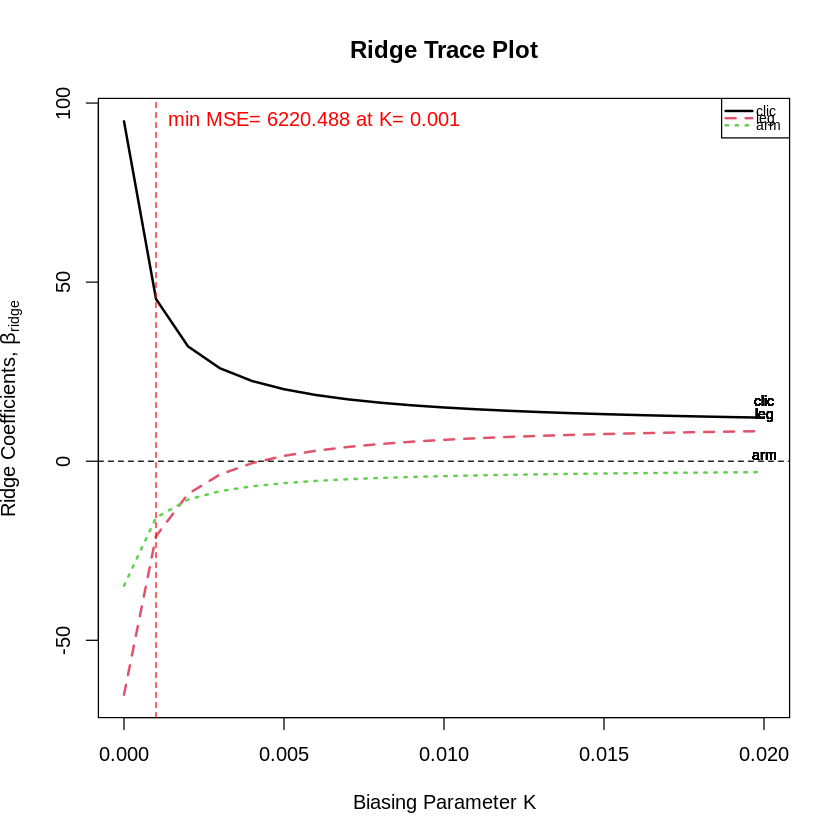

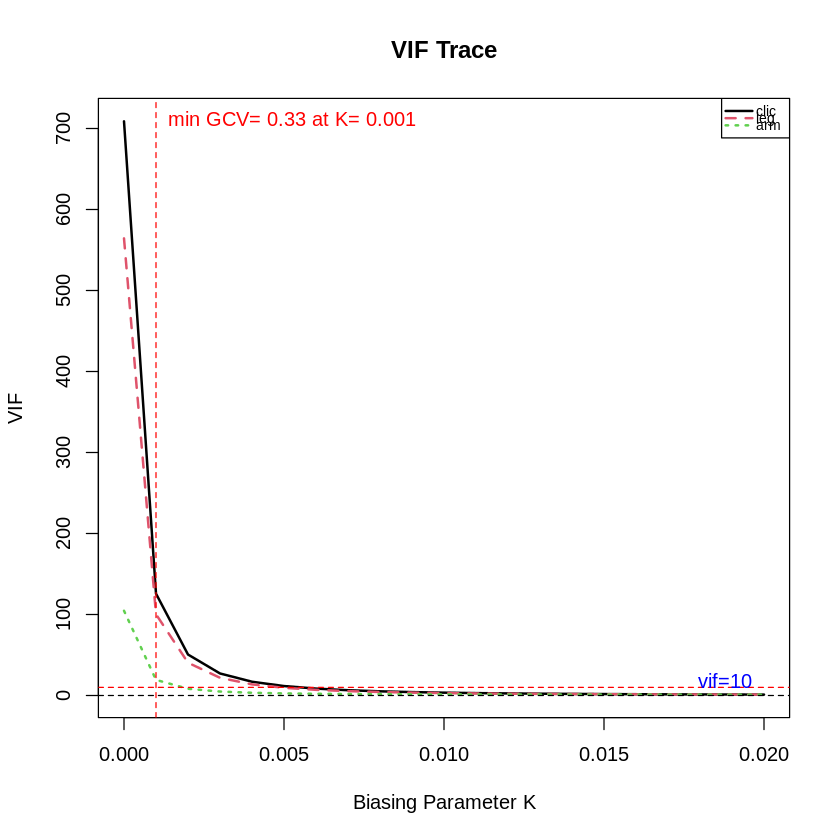

In [3]:
modelo <- lmridge(cmi~., masa_corporal, K = seq(0, 0.02, 0.001), scaling = "sc")
print(vif(modelo))
plot(modelo)
plot(modelo, type = "vif")

Nos quedamos con un parámetro $\lambda = 0.006$ ya que es el menor en la búsqueda que logra un VIF para cada predictor menor a 10.

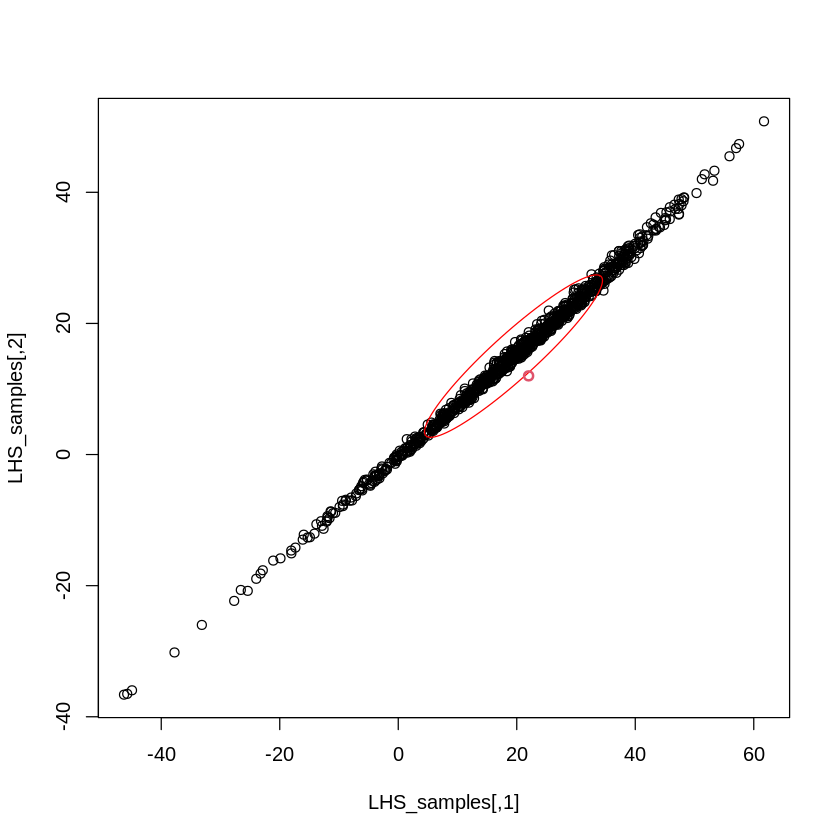

In [7]:
X <- masa_corporal[, c("clic", "leg", "arm")]
y <- masa_corporal[, "cmi"]

a_1 <- c(24, 56, 26)
a_2 <- c(20, 43, 24)
c1 <- 22
c2 <- 12
n_train <- nrow(X)
n_bootstraps <- 1000
is_ridge <- TRUE

K <- 0.006
scaling <- "sc"

result <- graph_h0(X = X, y = y, a_1 = a_1, a_2 = a_2, c1 = c1, c2 = c2,
                   n_train = n_train, n_bootstraps = n_bootstraps,
                   is_ridge = is_ridge, K = K, scaling = scaling)

El resultado es evidente. El punto $(c_{1}, c_{2})$ cae dentro de la elipse y por lo tanto no rechazamos que las expresiones lineales de los $\beta$ sean iguales a estos valores.

### Problem 2. Método de estimación robusta.

La estimación robusta resulta ser bastante útil para evitar que algunos puntos observados creen sesgo enla recta estimada. Además de la regresión con minimización de las desviaciones en valor absoluto, otra solución al problema, es cambiar la distribución de los erroes para que no sea normal, sino que permita la existencia de datos atípicos (sobre todo en $Y$), esto es _fat tailed distribution_. En ese caso, supondremos que los errores del modelo son proporcionales a una variable aleatoria con distribución $t$ de Student. Es decir, se define el modelo

$$
Y_{i} = X_{i}^{T}\beta + \varepsilon_{i}.
$$

Donde $\frac{\varepsilon_{i}}{\sigma} \sim t(\nu)$, donde $\nu$ son los grados de libertad correspondientes, y $\sigma$ es un parámetro que permita adapatar la dispersión de los datos. En este modelo, se deben estimar los parámetros de la recta, así como el parámetro de dispersión $\sigma$. Sin embargo, no es posible usar mínimos cuadrados dado que la distribución no es normal y se tendrían valores influyentes. Para estimar, se debe hacer por el método de máxima verosimilitud. Para simplificar el problema, suponga que $p = 2$, es decir, se deben estimar el intercepto, la pendiente y $\sigma$. Esto es,

$$
  \left(\frac{Y_{i}-\beta_{0}-\beta_{1}X_{i}}{\sigma}\right)\sim t(\nu)
$$

para cada $i = 1,2,\cdots,n$, y son independientes entre sí.

#### 1. Construya una función en R que tenga como inputs el vector $Y$, la matrix $X$, los parámetros $\beta_{0}$ y $\beta_{1}$ y el parámetro de dispersión $\sigma$. El output de la función debe ser la verosimilitud calculada. Pueden usar las funciones relacionadas con la distribución $t$ en R. Tenga en cuenta que esta es la función de verosimilitud $L(\beta_{0}, \beta_{1}, \sigma | Y, X)$ en términos de los tres parámetros, la cual se debe optimizar.

Primero, preparamos los datos con los que va a trabajar el modelo:

In [ ]:
library(readr)
data <- read_table("Archivos/datospunto2.txt", col_names = FALSE, skip = 1)
data <- data[,-1]
colnames(data) = c("y", "X")
X <- as.matrix(data["X"])
y <- as.matrix(data["y"])


Creamos la función que calcula la verosimilitud. Como tenemos varias ovservaciones, se calcula como el producto de la pdf (t de student) evaluada para cada observación. Suponemos $\nu = 3$.

In [ ]:
neg_L <- function(beta_0, beta_1, sigma, y, X, nu = 8){
  -prod(dt((y - beta_0 - beta_1 * X) / sigma, nu))
}


#### 2. Como es difícil encontrar la solución del máximo de $L(\beta_{0}, \beta_{1}, \sigma|Y, X)$ analíticamente, se deben usar métodos numéricos. Por ejemplo, para optimizar la función puede usar un método general construido en R como la función `optim`. Usando la función optim, maximice la verosimilitud $L(\beta_{0}, \beta_{1}, \sigma|Y, X)$ mediante un algoritmo iterativo en el cual se maximiza para cada parámetro a la vez:

1. Empiece con valores iniciales para $\beta_{0}^{(0)}$, $\beta_{1}^{(0)}$ y $\sigma^{(0)}$.

2. Repita hasta convergencia para la iteración $i \in \{1, 2, \cdots\}$:
    1. Maximice la función de verosimilitud con respecto a $\beta_{0}$ con valores fijos $\beta_{1}^{(i - 1)}$ y $\sigma^{(i-1)}$. Guarde el máximo como $\beta_{0}^{(i)}$.
    
    2. Maximice la función de verosimilitud con respecto a $\beta_{1}$ con valores fijos $\beta_{0}^{(i)}$ y $\sigma^{(i-1)}$. Guarde el máximo como $\beta_{1}^{(i)}$.
    
    3. Maximice la función de verosimilitud con respecto a $\sigma$ con valores fijos $\beta_{1}^{(i)}$ y $\beta_{1}^{(i)}$. Guarde el máximo como $\sigma^{(i)}$.

In [ ]:
# Los parámetros al llamar la función por primera vez son el resultado del estimador por OLS.
OptQuest <- function(beta_0, beta_1, sigma, y, X, nu = 8, min_obj_change = 0.00000001){
  init_obj <- neg_L(beta_0, beta_1, sigma, y, X, nu)
  print(init_obj)
  repeat{
    sol <- optim(beta_0, fn = neg_L,beta_1 = beta_1, sigma = sigma, y = y, X = X, nu = nu)
    beta_0 <- sol$par
    
    sol <- optim(beta_1, fn = neg_L, beta_0 = beta_0, sigma = sigma, y = y, X = X, nu = nu)
    beta_1 <- sol$par
    
    sol <- optim(sigma, fn = neg_L, beta_0 = beta_0, beta_1 = beta_1, y = y, X = X, nu = nu)
    beta_1 <- sol$par

    new_obj <- sol$value
    if(init_obj - new_obj < min_obj_change){
      break
    } else {
      init_obj <- new_obj
    }
  }
  return(list(beta_0 = beta_0, beta_1 = beta_1, sigma = sigma, obj_val = new_obj))
}

# Estimamos los parámetros iniciales por OLS para iniciar el optimizador.
model <- lm(y ~ X, data = data)

OptQuest(model$coefficients[["(Intercept)"]], model$coefficients[["X"]], sqrt(deviance(model)/df.residual(model)), y, X, 8)


#### 3. Construya una mecanismo de inferencia por medio de bootstrap para construir intervalos de confianza para los tres parámetros de interés. Use los datos anexos datospunto3.txt y reporte los intervalos de confianza para $\beta_{0}^{(0)}$, $\beta_{1}^{(0)}$ y $\sigma^{(0)}$ con 95% y con 99% de confianza. Puede usar 8 grados de libertad.

Bootstrap nos permite hacer un muestreo de los parámetros estimados por verosimilitud. El desarrollo debe tomar muestras de los datos originales con reemplazo y entrenar el modelo de regresión robusto para cada muestra aleatoria. El intervalo se calcula a partir de percentiles.

In [ ]:
bootstrap_robust_regression <- function(n_obs = length(y), n_bootstraps = 1000){
  beta_0_sampled <- rep(0, n_bootstraps)
  beta_1_sampled <- rep(0, n_bootstraps)
  sigma_sampled <- rep(0, n_bootstraps)
  
  for (i in 1:n_bootstraps) {
    indices <- sample(1:length(y), n_obs)
    X_sample <- X[indices]
    y_sample <- y[indices]
    
    model <- lm(y ~ X_sample, y = y_sample)
    
    result <- OptQuest(model$coefficients[["(Intercept)"]], model$coefficients[["X_sample"]], sqrt(deviance(model)/df.residual(model)), y, X, 8)
    beta_0_sampled[i] = result$beta_0
    beta_1_sampled[i] = result$beta_1
    sigma_sampled[i] = result$sigma
  }
  
  return(list(beta_0_intervals = list(conf.95 = quantile(beta_0_sampled,
                                                         c(0.025, 0.975)),
                                      conf.99 = quantile(beta_0_sampled,
                                                         c(0.005, 0.995))),
              beta_1_intervals = list(conf.95 = quantile(beta_1_sampled,
                                                         c(0.025, 0.975)),
                                      conf.99 = quantile(beta_0_sampled,
                                                         c(0.005, 0.995))),
              sigma_intervals  = list(conf.95 = quantile(sigma_sampled,
                                                         c(0.025, 0.975)),
                                      conf.99 = quantile(beta_0_sampled,
                                                         c(0.005, 0.995)))))
}

bootstrap_robust_regression()


## Parte B. Problemas teóricos, conceptuales y experimentales.

### Problema BONO. Uso de _leverage_ para medidas de desempeño.

Si $H$ es la matriz de proyección en $\Omega$ definida por el estimador de mínimos cuadrados, entonces los elementos de la diagonal $\ell_{ii}$ son los valores de _leverage_ que se miden para cada observación. Como se ha visto, estos valores tienen muchos usos, como por ejemplo, determinar la varianza de los residuales o determinar datos atípicos en $\textbf{X}$. Uno de los usos más útiles, es que permiten calcular la distancia de un punto $Y_{i}$ a la recta estimada sin ese punto, sin necesidad de correr el modelo con los $n-1$ datos restantes. Es decir:

$$
    \left( Y_{i} - \hat{Y}_{i,(i)} \right) = \frac{Y_{i}-\hat{Y}_{i}}{1-\ell_{i,i} },
$$

donde $\hat{Y}_{i,(i)}$ es la estimación del valor esperado de $Y_{i}$ estimada con el modelo que usa todos los datos, menos la observación $i$.

Esto quiere decir, que si se define la métrica LOOCV:

$$
    LOO = \frac{1}{n}\sum_{i=1}^{n}\left( \frac{Y_{i}-\hat{Y}_{i}}{1-\ell_{i,i} } \right)^{2}
$$

entonces, se puede medir el desempeño del modelo, algo parecido a como lo hace el $R^{2}_{\text{adj}}$, el $C_{p}$ de Mallows o el $\text{AIC}$.

$\mathcal{\ell} + \ell$

1. Demuestre que

$$
    \ell_{i,i} = \frac{d\hat{Y}_{i}}{dY_{i}}.
$$

+ Respuesta

$$
    \begin{align*}
        \hat{Y} &= HY \\
        \hat{Y}_{i} &= H_{i}Y \text{ (Acá, }H_{i}\text{ es la fila }i\text{ de la matriz }H)\\
        \hat{Y}_{i} &= H_{i, 1}Y_{1} + H_{i, 2}Y_{2} + \cdots + H_{i, i}Y_{i} + \cdots +H_{i, n}Y_{n}\\
        \frac{d\hat{Y}_{i}}{dY_{i}} &= \frac{dH_{i, 1}Y_{1}}{dY_{i}} + \frac{dH_{i, 2}Y_{2}}{dY_{i}} + \cdots + \frac{dH_{i, i}Y_{i}}{dY_{i}} + \cdots + \frac{dH_{i, n}Y_{n}}{dY_{i}}\\
        \frac{d\hat{Y}_{i}}{dY_{i}} &= \frac{dH_{i, i}Y_{i}}{dY_{i}} = H_{ii} = \ell_{i,i}\\
    \end{align*}
$$

2. Con la información del numeral anterior, demuestre que:

$$
    \frac{dY_{i}}{de_{i}} = \frac{1}{1-\ell_{i,i}}
$$

+ Respuesta

$$
    \begin{align*}
        e &= Y - HY \\
        e &= (I - H)Y \\
        e_{i} &= (I - H)_{i}Y \text{ (Acá, }(I-H)_{i}\text{ es la fila }i\text{ de la matriz }I-H)\\
        e_{i} &= (0 - H_{i, 1})Y_{1} + (0-H_{i, 2})Y_{2} + \cdots + (1-H_{i, i})Y_{i} + \cdots + (0-H_{i, n})Y_{n}\\
        e_{i} &= -H_{i, 1}Y_{1} - H_{i, 2}Y_{2} - \cdots + (1-H_{i, i})Y_{i} - \cdots - H_{i, n}Y_{n}\\
        (H_{i, i} - 1)Y_{i} &= H_{i, 1}Y_{1} + H_{i, 2}Y_{2} + \cdots + H_{i, n}Y_{n} - e_{i}\\
        Y_{i} &= \frac{H_{i, 1}Y_{1}}{(H_{i, i} - 1)} + \frac{H_{i, 2}Y_{2}}{(H_{i, i} - 1)} + \cdots + \frac{H_{i, n}Y_{n}}{(H_{i, i} - 1)} - \frac{e_{i}}{(H_{i, i} - 1)}\\
        \frac{dY_{i}}{de_{i}} &= - \frac{d\frac{e_{i}}{(H_{i, i} - 1)}}{de_{i}}\\
        \frac{dY_{i}}{de_{i}} &= \frac{1}{1 - H_{i, i}} = \frac{1}{1 - \ell_{i, i}}\\
    \end{align*}
$$

3. Con la información de los dos numerales anteriores, demuestre (explique) por qué:

$$
    d_{i} = \frac{e_{i}}{1 - \ell_{i,i}}.
$$

+ Respuesta

Sea $d_{i} = Y_{i} - \hat{Y}_{i, (i)}$, entonces:

$$
    \begin{align*}
         d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta}_{(i)} \right]\\
         d_{i} &= Y_{i} - X_{i}\left[\left( X_{(i)}^{T}X_{(i)} \right)^{-1} X_{(i)}^{T}Y_{(i)}\right]
    \end{align*}
$$

Hacemos uso de la ecuación de Sherman-Morrison-Woodbury.

$$
    \begin{align*}
         d_{i} &= Y_{i} - X_{i}\left[\left[ \left(X^{T}X\right)^{-1} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}}{1 + X_{i}^{T}\left(X^{T}X\right)^{-1}X_{i}} \right] X_{(i)}^{T}Y_{(i)}\right]\\
         d_{i} &= Y_{i} - X_{i}\left[\left[ \left(X^{T}X\right)^{-1} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}}{1 - \ell_{i,i}} \right] X_{(i)}^{T}Y_{(i)}\right]\\
         d_{i} &= Y_{i} - X_{i}\left[\left[ \left(X^{T}X\right)^{-1} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}}{1 - \ell_{i,i}} \right] \left(X^{T}Y - X_{i}^{T}Y_{i} \right)\right]\\
    \end{align*}
$$

Simplificamos:

$$
    \begin{align*}
        d_{i} &= Y_{i} - X_{i}\left[ \left(X^{T}X\right)^{-1}X^{T}Y - \left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}X^{T}Y}{1 - \ell_{i,i}} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i}}{1 - \ell_{i,i}} \right]\\
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \hat{\beta}}{1 - \ell_{i,i}} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}\ell_{i,i}Y_{i}}{1 - \ell_{i,i}} \right]\\
    \end{align*}
$$

Factorizamos el $\left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i}$ y el $\left(X^{T}X\right)^{-1}X_{i}^{T}$:

$$
    \begin{align*}
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i}(1 + \frac{\ell_{i,i}}{1-\ell_{i,i}}) + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \hat{\beta}}{1 - \ell_{i,i}} \right]\\
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}Y_{i}}{1-\ell_{i,i}} + \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}X_{i} \hat{\beta}}{1 - \ell_{i,i}} \right]\\
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}(Y_{i}-X_{i} \hat{\beta})}{1-\ell_{i,i}} \right]\\
        d_{i} &= Y_{i} - X_{i}\left[ \hat{\beta} - \frac{\left(X^{T}X\right)^{-1}X_{i}^{T}e_{i}}{1-\ell_{i,i}} \right]\\
        d_{i} &= Y_{i} + \left[ \frac{X_{i}\left(X^{T}X\right)^{-1}X_{i}^{T}e_{i}}{1-\ell_{i,i}} - \hat{Y}_{i}\right]\\
        d_{i} &= e_{i} + \frac{X_{i}\left(X^{T}X\right)^{-1}X_{i}^{T}e_{i}}{1-\ell_{i,i}}\\
        d_{i} &= e_{i} + \frac{\ell_{i,i}e_{i}}{1-\ell_{i,i}}\\
        d_{i} &= \frac{(1-\ell_{i,i})e_{i} + \ell_{i,i}e_{i}}{1-\ell_{i,i}}\\
        d_{i} &= \frac{(1-\ell_{i,i} + \ell_{i,i})e_{i}}{1-\ell_{i,i}} = \frac{e_{i}}{1-\ell_{i,i}}\\
    \end{align*}
$$

4. Con los datos de `masa-corporal` que vimos en las clases de multicolinealidad, seleccione el modelo más apropiado para explicar el índice de grasa corporal. Compare el resultado con el obtenido si usa: $R^{2}_{adj}$, $C_{p}$ y $\text{AIC}$.

### Problema 3. Problemas de especificación y selección de modelos.

## Parte C. Problemas aplicados con datos reales.

### Problema 4. Ventas de secadoras eléctricas en Bogotá.

#### 1. Revise todos los supuesto del modelo que sean pertinentes. Realice las pruebas que considere necesarias.

Los supuestos del modelo que se deberían revizar corresponde a  verificar normalidad, autocorrelación, multicolinealidad,  heteroscedasticidad y, tambien se debe verificar si existen o no datos outliers e influyentes. Dado lo anterior se realizan algunas pruebas correspondiente para evaluar cada uno de los supuestos presentados. 

Antes de comenzar se cargan los datos y se general em modelo de regresión lineal correspondiente. 


In [4]:
library(readr)
library(MASS)
library(car)
library(leaps)
library(lmtest)

secadoras <- read.table("Archivos/secadoras.txt", head = TRUE)
head(secadoras)

y <- secadoras$ventas
precio <- secadoras$precio
consumo <- secadoras$consumo
publicidad <- secadoras$publicidad
competencia <- secadoras$competencia

modelo <- lm(y~precio+consumo+publicidad+competencia)
summary(modelo)


,ventas,precio,consumo,publicidad,competencia
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-51.86530,12.730041,5.120954,7.883980,3.358127
2,-24.59515,12.923566,9.128683,9.978578,8.737131
3,-30.71430,7.123548,8.091998,9.577806,2.688939
4,-39.84182,10.145909,7.104766,10.780311,5.617165
5,-60.28946,11.641656,6.877741,9.192014,1.909947
6,-64.63831,12.139542,7.248237,7.045200,2.517575



Call:
lm(formula = y ~ precio + consumo + publicidad + competencia)

Residuals:
    Min      1Q  Median      3Q     Max 
-53.310  -7.222  -1.668   9.079  38.884 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  19.1644    12.9062   1.485  0.14289    
precio       -3.7720     0.8316  -4.536 2.87e-05 ***
consumo      -9.0379     0.9525  -9.488 1.77e-13 ***
publicidad    3.0562     1.0849   2.817  0.00658 ** 
competencia   2.9156     0.9476   3.077  0.00317 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15.73 on 59 degrees of freedom
Multiple R-squared:  0.6911,	Adjusted R-squared:  0.6702 
F-statistic:    33 on 4 and 59 DF,  p-value: 1.901e-14


###### Normalidad
Para el caso del supuesto de normalidad lo primero que se hace es obtener los residuos y a partir de esto, se gráfica el ajuste a través de una Q-Q Plot como lo vemos a continuación:

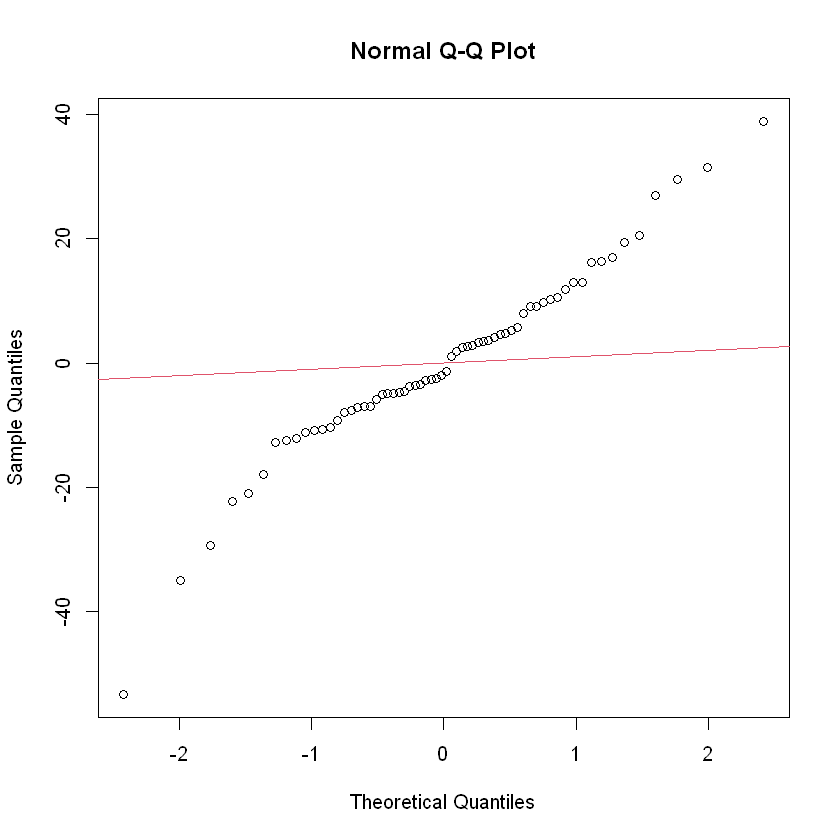

In [7]:
#Normalidad
residuos <- modelo$residuals
qqnorm(residuos)
abline(0,1,col=2)

En la anterior gráfica se puede ver que el comportamiento de los datos no es normal debido a que están muy lejanos de la recta con pendiente 1 que pasa por el origen. 

Sin embargo, como es una observación gráfica, procedemos a comprobar lo anteriro de manera estadística por medio de la la prueba Shapiro en donde se plantea la siguiente prueba de hipótesis:

$$
H_0: e_{i} \sim \ Normal
$$

$$
H_1:\lnot\ H_0
$$


In [9]:
#Normalidad - Shapiro 
shapiro.test(residuos)


	Shapiro-Wilk normality test

data:  residuos
W = 0.96241, p-value = 0.04867


Con un nivel de confianza del 95% se rechaza la hipotesis nula, es decir que se puede concluir que los residuos del modelo no se distribuyen normales dado que al realizar la prueba de Shapiro el p-value = 0.04867 lo cual es menor a 5%

###### Autocorrelación
Para evaluar si hay o no autocorrelación entre los datos del modelo se decir realizar dos pruebas, la primera es la prueba de Durbin-Watson y la segunda la de Breusch-Godfrey.

* Prueba Durbin-Watson:
$$
H_0:\rho=0
$$

$$
H_1: \rho>0
$$


In [10]:
#Autocorrelacion
dwtest(modelo)


	Durbin-Watson test

data:  modelo
DW = 2.1838, p-value = 0.7863
alternative hypothesis: true autocorrelation is greater than 0


Como se puede ver, el resultado de la prueba de Durbin.Watson arrojó un p-value = 0.7863, por lo que no se rechaza la hipotesis nula dado que el p-value > 5%, es decir que con una confianza del 95% que no hay problemas de autocorrelación. 



* Prueba Breusch-Godfrey:
$$
H_0: \rho_i=0  \ \ \forall \ i\in N
$$

$$
H_1:\lnot\ H_0
$$

In [11]:
#Autocorrelacion
bgtest(modelo)


	Breusch-Godfrey test for serial correlation of order up to 1

data:  modelo
LM test = 0.62711, df = 1, p-value = 0.4284


Como se puede ver, el resultado de la prueba de Breusch-Godfrey arrojó un p-value = 0.4284, por lo que no se rechaza la hipotesis nula dado que el p-value > 5%, es decir que con una confianza del 95% que no hay problemas de autocorrelación. 


Es claro, por las dos pruebas realizadas que se puede concluir que los datos cumplen con el supuesto de la no autocorrelación. 

###### Multicolinealidad
Para ver si hay o no problemas de multicolinealidad lo primero que se decide hacer es graficar el comportamiento de las variables

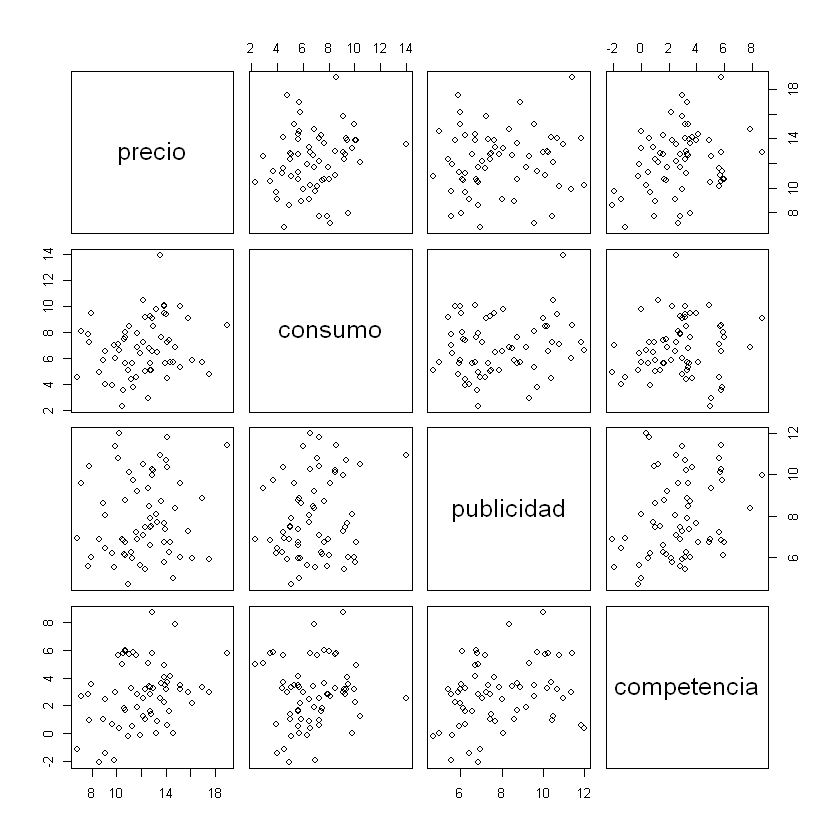

In [12]:
#Multicolinealidad
pairs(secadoras[,2:5])

Gráficamente no es claro que haya una tendencia entre los datos, pues se ve que las nubes de puntos no tienen una tendencia aparente, es decir que se puede pensar que no hay problemas de multicolinealidad. Sin embargo, para estar seguros se decide obtener los VIF del modelo. Si se llega a obtener algun VIF con un valor muy grande (aprox. mayor a 10) se considera que hay problemas de multicolinealidad. 

In [13]:
vif(modelo)

precio     consumo  publicidad competencia 
   1.116039    1.065189    1.105493    1.163187

Como se puede ver en cada uno de los VIF, ninguno es mayor a 10, en realidad son valores muy bajos pues no sobre pasan el 1.2, por tal motivo se puede concluir que el modelo no tiene problemas de multicolinealidad. 

###### Heterocedasticidad
Se procede ahora a evaluar el supuesto de homocedasticidad, para esto se realiza la prueba de Breusch-Pagan que consiste en evaluar el siguiente modelo:
$$
e_{i^2}=\alpha_0+\alpha_1X_{1i}+\alpha_2X_{2i}+\alpha_3X_{3i}+\alpha_4X_{4i}+w_i
$$

y se plantea la siguiente prueba de hipotesis: 
$$
H_0: \alpha_1 = \alpha_2 =\alpha_3 =\alpha_4= 0
$$

$$
H_1: al menos un \alpha \neq 0
$$

In [20]:
#Heteroscedasticidad
bptest(modelo)


	studentized Breusch-Pagan test

data:  modelo
BP = 10.251, df = 4, p-value = 0.03641


Al realizar la prueba se puede concluir que con un nivel de confianza del 95% hay suficiente evidencia estadística para rechazar $H_0$, es decir que efectivamente hay problemas de heteroscedasticidad, dado que el p-value es 0.03641 lo cual es menor a 5% que es el nivel de significancia. 

Dado que se encontró problemas de heteroscedasticidad, se realizó la evaluación de las variables en las cuales se encuentran problemas de heteroscedasticidad dentro del modelo:

In [22]:
residuos2 <- residuos^2
n <- length(y)

model1 <- lm(residuos2~precio) 
pvalor1 <- 1-pchisq(n*summary(model1)$r.squared,1)

model2 <- lm(residuos2~consumo) 
pvalor2 <- 1-pchisq(n*summary(model2)$r.squared,1)

model3 <- lm(residuos2~publicidad) 
pvalor3 <- 1-pchisq(n*summary(model3)$r.squared,1)

model4 <- lm(residuos2~competencia) 
pvalor4 <- 1-pchisq(n*summary(model4)$r.squared,1)

pvalores <- c(pvalor1,pvalor2,pvalor3,pvalor4)
pvalores

[1] 0.90603417 0.02492710 0.65430577 0.02274397

Al observar los p-values de cada una de las variables se puede concluir que las variables de Consumo y Competencia son las que están generando los problemas de heteroscedasticidad esto dado que los p-value de estas dos variables son menores a nuestro nivel de significancia del 5%. 

###### Outliers e Influyentes
Como primer paso se procede a revisar los datos outliers de manera gráfica mediante los residuos de la siguiente manera: 

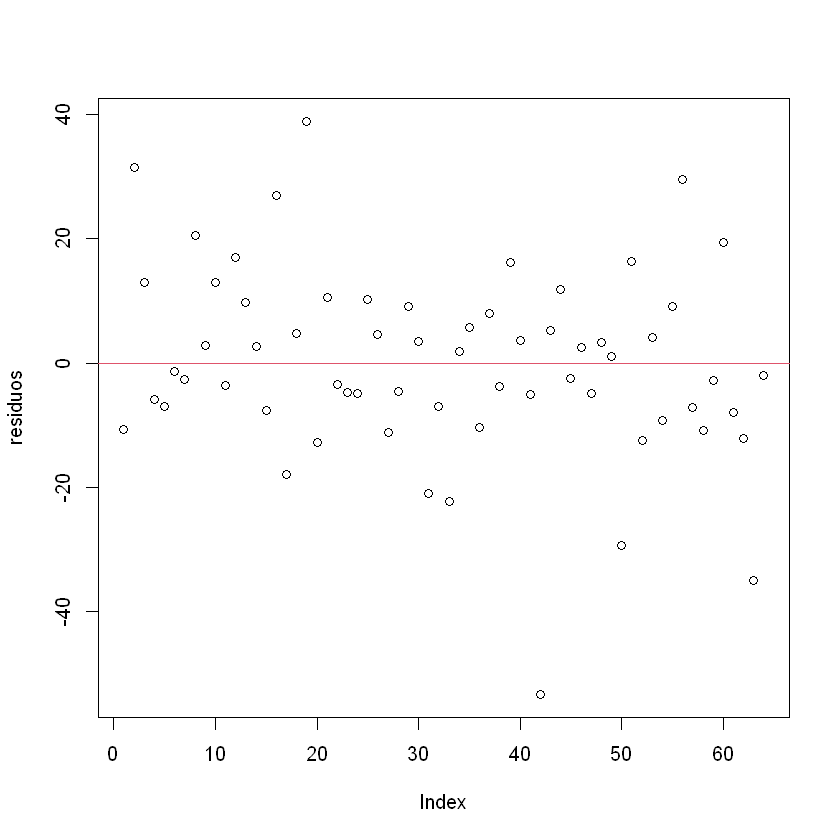

In [23]:
#Datos outliers
plot(residuos)
abline(0,0, col=2)

En la anterior gráfica es posible observar que hay algunos datos (puntos) que se encuentran alejados del ceo, o de la linea roja, dado esto, se procede a realizar la comprobación estadística que empieza al estudentizar los residuos de la siguiente manera:

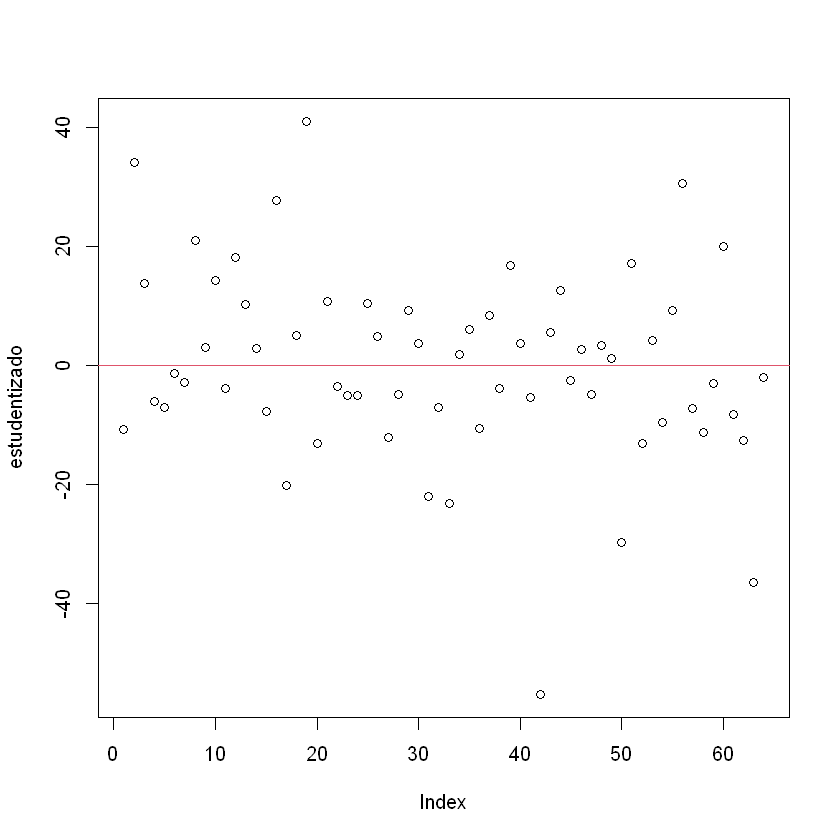

In [68]:
#estudentizar 
x <- as.matrix(cbind(rep(1,64), secadoras[,2:5]))
H <- x %*% solve(t(x) %*% x) %*% t(x)
leve <- diag(H)

estudentizado <- residuos/sqrt(1-leve)
plot(estudentizado)                
abline(0,0,col=2)   

Luego, con los datos estudentizados se procede a realizar el análisis de datos outliers e influyentes con el siguiente procedimiento, en donde se comprobará si hay datos outliers o no.

In [69]:
# Datos outliers
p <- dim(secadoras)[2]-1
t <- residuos*sqrt((n-p-1)/(sum((y-predict(modelo))^2)*(1-leve)-residuos^2))
max(t)
qt(0.95,n-p-1)

[1] 2.77419

[1] 1.671093

Se evalúa la existencia de datos influyentes con un valor de 2.7741 contra una $t_{59}$=1.671 y se puede concluir con un nivel de confianza del 95% que existen datos outliers dado que EP < t.

In [70]:
# Datos influyentes
cd <- cooks.distance(modelo)
max(cd)
qf(0.5,p,n-p)

[1] 0.193887

[1] 0.8487321

La prueba utilizada para saber si hay o no datos atipicos fue la distancia de Cook. La cual arrojó un valor de 0.1939 que al compararlo con la distribución F(p,n-p)=0,8487 se puede concluir con una significancia del 5% que no hay datos influyentes en el modelo, pues el valor de Di no es lo suficiente mente grande comparado con la mediana de
la distribución F mencionada. 

#### 2. Encuentre una manera de solucionar el problema de las varianzas.

Para solucionar el problema de las varianzas se debe recordar los datos obtenidos en la prueba de heteroscedasticidad en donde se demostró que los problemas se encuentran en las varaibles: consumo y competencia. 
Teniendo lo anterior claro, para solucionar el problema se procede a utilizar Mínimos Cuadrados Ponderados Factibles (FWLS). 

Lo primero que se debe hacer es calcular la matriz:
$$
\hat{\Omega}=\left[\begin{matrix}{\hat{\sigma}}_1^2&\cdots&0\\\vdots&\ddots&\vdots\\0&\cdots&{\hat{\sigma}}_n^2\\\end{matrix}\right]
$$
Para poder encontrar los betas y las varianzas se emplean las siguientes ecuaciones:
$$
{\hat{\beta}}_{FWLS}=(X^T {\hat{\Omega}}^{-1} X)^{-1}(X^T {\hat{\Omega}}^{-1} Y)
$$

$$
{\widehat{Var}}_{FWLS}=(X^T {\hat{\Omega}}^{-1} X)^{-1}((X^T \hat{\Lambda} X))(X^T {\hat{\Omega}}^{-1} Y)^{-1}
$$

Sabiendo que:
$$
\hat{\Lambda}=\left[\begin{matrix}\frac{\left(e_{j_1}\right)^2}{\left({\hat{\sigma}}_1^2\right)^2}&\cdots&0\\\vdots&\ddots&\vdots\\0&\cdots&\frac{\left(e_{j_n}\right)^2}{\left({\hat{\sigma}}_n^2\right)^2}\\\end{matrix}\right]
$$

In [72]:
logresiduos2 <- log(residuos2)
regresionlog <- lm(logresiduos2~consumo)
summary(regresionlog)

mconsumo <- as.matrix(cbind(rep(1,n), consumo))
alpha <- regresionlog$coefficients
lhat <- exp(mconsumo %*% alpha)

sigma2 <- diag(as.numeric(lhat))
xwx <- solve(t(x) %*% solve(sigma2) %*% x)
betasFWLS <- xwx %*% t(x) %*% solve(sigma2) %*% y

v <- matrix(rep(0,64*64),ncol=64)
resinew <- (y-x %*% betasFWLS)^2
v <- diag(as.numeric(resinew / diag(sigma2^2)))
varFWLS <- xwx %*% t(x) %*% v %*% x %*% xwx
varFWLS
diag(varFWLS)

logerror <- predict(regresionlog)
error <- exp(logerror)

modelonew <- lm(y~precio + consumo + publicidad + competencia, weights = 1/error)
summary(modelonew)


Call:
lm(formula = logresiduos2 ~ consumo)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5056 -1.0302  0.0569  1.0845  3.4462 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  2.40209    0.70245   3.420  0.00111 **
consumo      0.24809    0.09814   2.528  0.01404 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.672 on 62 degrees of freedom
Multiple R-squared:  0.09344,	Adjusted R-squared:  0.07882 
F-statistic:  6.39 on 1 and 62 DF,  p-value: 0.01404


,"rep(1, 64)",precio,consumo,publicidad,competencia
"rep(1, 64)",61.8765896,-2.4217174,-0.4465377,-4.0217233,0.7171486
precio,-2.4217174,0.3972577,-0.2739401,0.0149117,-0.3346344
consumo,-0.4465377,-0.2739401,0.7437502,-0.1847683,0.4873066
publicidad,-4.0217233,0.0149117,-0.1847683,0.6646581,-0.1647921
competencia,0.7171486,-0.3346344,0.4873066,-0.1647921,0.7032191


rep(1, 64)      precio     consumo  publicidad competencia 
 61.8765896   0.3972577   0.7437502   0.6646581   0.7032191


Call:
lm(formula = y ~ precio + consumo + publicidad + competencia, 
    weights = 1/error)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-5.8604 -0.9888 -0.1396  1.2362  4.0739 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  18.5547    11.0620   1.677 0.098769 .  
precio       -4.2095     0.7203  -5.844 2.34e-07 ***
consumo      -8.1084     0.9022  -8.988 1.20e-12 ***
publicidad    3.0404     0.9873   3.080 0.003145 ** 
competencia   2.9430     0.7925   3.714 0.000455 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.819 on 59 degrees of freedom
Multiple R-squared:  0.7253,	Adjusted R-squared:  0.7067 
F-statistic: 38.94 on 4 and 59 DF,  p-value: 6.267e-16


En el modelo anterior podemos ver los nuevos betas y tambien se muestra la amtriz de varianzas resultante. Con esto se debe entonces ver si con esta corrección solucionamos o no los problemas de heteroscedasticidad. Para lo cual se realiza una prueba de Breusch-Pagan y se plantea la siguiente prueba de hipotesis: 
$$
H_0: \alpha_1 = \alpha_2 = \alpha_3 = \alpha_4 = 0
$$

$$
H_1:Al menos un \alpha \neq 0
$$

In [74]:
resinew2 <- modelonew$residuals^2
modelobp <- lm(resinew2~precio + consumo + publicidad + competencia)
bptest(modelobp)


	studentized Breusch-Pagan test

data:  modelobp
BP = 4.2568, df = 4, p-value = 0.3724


Con este p-value = 0.3724 que es mayor a 5%, se puede concluir que el modelo ya no presenta problemas de heteroscedasticidad con un nivel de confianza del 95% dado que no se rechaza $H_0$.

#### 3. Un reconocido economista afirma que el efecto del precio es el mismo que el de la competencia pero son signo contrario, y además que el efecto del consumo de energía es cuatro veces que el del gasto en publicidad con signo contrario. Cree Usted que los datos contradicen la afirmación del economista? Use al menos dos formas diferentes adecuadas para probar esta hipótesis

Para probar si la afirmación del economista es cierta o no, se utiliza una  prueba de Wald con la siguiente prueba de hipótesis:
$$
H_0:\ \ \ \left\{\begin{matrix}\beta_{1\ \left(FWLS\right)}+\beta_{4\ \left(FWLS\right)}=0\\\beta_{2\ \left(FLWS\right)}+4{\cdot\beta}_{3\ \left(FWLS\right)}=0\\\end{matrix}\right.
$$

$$
H_1:\ \ \ \lnot\ H_0
$$



In [77]:
a <- matrix(c(0,1,0,0,1,0,0,1,4,0),ncol=5,byrow = T)
EP <- t(a %*% betasFWLS) %*% solve(a %*% varFWLS %*% t(a)) %*% (a %*% betasFWLS)
EP
wcr <- qchisq(0.95,2) 
wcr

4.611612


[1] 5.991465

Como se puede observar el valor del estadístico de prueba es $EP = 4.6116$ y el $w_{cr}=5.9915$. Cómo el $EP<w_{cr}$ entonces se puede concluir, bajo un nivel de confianza del 95% que no se rechaza la $H_0$, por lo cual no hay suficiente evidencia estadística para rechazar la afirmación del economista.

### Problema 5. Efectos de medidas preventivas en la severidad del coronavirus.

Una de las preguntas más comunes en política de salud pública en la actualidad, es determinar el efecto de las medidas de restricción de movilidad o de actividades que impliquen reducir el contacto entre personas. Esto es por ejemplo, las cuarentenas, el pico y cédula, la prohibición de clases presenciales, uso de tapabocas, etc. Por conveniencia, estas medidas han sido agrupadas en una sola métrica conocide con el _Stringency Index_. Para entender cómo se calcula, puede revisar los documentos relacionados en: https://covidtracker.bsg.ox.ac.uk/.

En un modelo simplificado, se quiere probar el efecto de esta medidas en Colombia (usando el _stringency
index_) sobre la tasa de mortalidad usando el modelo:

$$
    \log(MR_t) = \beta_0 + \beta_1 SI_t + \beta_2 \log(NC_t) + \varepsilon_t
$$

Donde $MR_t$ corresponde a la tasa de mortalidad (número de muertes por Covid por cada millón de habitantes) en el día $t$, $NC_t$ corresponde al número de casos confirmados (por cada millón de habitantes) durante los últimos 14 días antes de $t$, y $SI_t$ corresponde al promedio del _stringency index_ para los 14 días anteriores a $t$, es decir:

$$
    SI_t = \frac{\sum_{i = 1}^{14}strind_{t-i}}{14},
$$

$$
    NC_t = \sum_{i = 1}^{14} nc_t.
$$

$strind_t$ es la medida del _stringency index_ en el día $t$ y $nc_t$ es el número de casos confirmados en el día $t$. Para evitar problemas con los logaritmos, cuando las variables $MR_t$ o $NC_t$ tomen el valor de cero, entonces aproxímelos como 1. Si considera que en la base da datos existen variables importantes para tener un modelo mejor específicado, no dude en incluirlas.

Note que este modelo es definido sobre series de tiempo. Como periodo de estudio, use datos desde el noviembre 1 del 2020 hasta noviembre 1 de 2021. Para obtener los datos de las variables, puede revisar: https://ourworldindata.org/grapher/covid-stringency-index.

#### 1. Estime los parámetros del modelo e interpréte los intervalos de confianza correspondientes. Tenga en cuenta los logaritmos. ¿Encuentra coherencia en los resultados?

#### 2. ¿Considera que el modelo tiene problemas de heteroscedasticidad?

#### 3. Dado que el modelo se stima con series de tiempo, es posible que se presenten problemas de autocorrelación. Revise si existe autocorrelación positiva. En caso de que sea así, estime el modelo correcto y realice el intervalo de confianza para cada parámetro (incluyendo el intercepto).